# 

In [16]:
import transformers
print(transformers.__version__)


4.51.1


In [17]:
import pandas as pd

# Load both datasets
real_news = pd.read_csv('/kaggle/input/dl-projfake-news-dataset/True.csv')
fake_news = pd.read_csv('/kaggle/input/dl-projfake-news-dataset/Fake.csv')

# Assign labels
real_news['label'] = 1  # Real
fake_news['label'] = 0  # Fake

# Combine them into one dataframe
combined_df = pd.concat([real_news, fake_news], ignore_index=True)

# Shuffle the combined dataframe
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Keep only necessary columns
combined_df = combined_df[['title', 'text', 'label']]

# Combine title and text for better context
combined_df['content'] = combined_df['title'] + " " + combined_df['text']

# Clean text (optional but recommended)
import re

def clean_text(text):
    text = re.sub(r"http\S+", "", text)                    # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)             # remove special characters
    text = re.sub(r"\s+", " ", text)                       # remove extra whitespaces
    return text.strip()

combined_df['content'] = combined_df['content'].apply(clean_text)

# Drop the old columns
combined_df = combined_df[['content', 'label']]

# Save for tokenization step
combined_df.to_csv('preprocessed_news.csv', index=False)

print("✅ Data Preprocessing Completed! Saved as preprocessed_news.csv.")


✅ Data Preprocessing Completed! Saved as preprocessed_news.csv.


In [24]:
from transformers import RobertaTokenizer
from sklearn.model_selection import train_test_split
import torch
import pandas as pd  # Make sure you import pandas!

# Load the preprocessed data
df = pd.read_csv('preprocessed_news.csv')

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenization Function
def encode_texts(texts, tokenizer, max_len=512):
    return tokenizer(
        texts,  # texts must be a plain Python list
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

# Splitting into Train, Validation, and Test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['content'], df['label'], test_size=0.3, random_state=42, stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Convert Series to string lists and handle NaNs if any
train_texts = train_texts.astype(str).fillna("").tolist()
val_texts = val_texts.astype(str).fillna("").tolist()
test_texts = test_texts.astype(str).fillna("").tolist()

# Encode the datasets
train_encodings = encode_texts(train_texts, tokenizer)
val_encodings = encode_texts(val_texts, tokenizer)
test_encodings = encode_texts(test_texts, tokenizer)

# Convert labels to tensors
train_labels = torch.tensor(train_labels.values)
val_labels = torch.tensor(val_labels.values)
test_labels = torch.tensor(test_labels.values)

print("✅ Tokenization Complete!")
print(f"Train samples: {train_labels.shape[0]}")
print(f"Validation samples: {val_labels.shape[0]}")
print(f"Test samples: {test_labels.shape[0]}")


✅ Tokenization Complete!
Train samples: 31428
Validation samples: 6735
Test samples: 6735


In [19]:
from transformers import RobertaForSequenceClassification

# Load the RoBERTa model with 2 output labels (binary classification)
roberta_model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=2
)

print("✅ RoBERTa Model loaded successfully!")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ RoBERTa Model loaded successfully!


In [10]:
print(len(train_texts), len(val_texts))  # Make sure sizes match expected split


31428 6735


In [26]:
import torch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_scheduler
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.optim import AdamW  



# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load dataset
# df = pd.read_csv("preprocessed_news.csv")

# # Encode labels
# label_encoder = LabelEncoder()
# df["label"] = label_encoder.fit_transform(df["label"])

# # Split dataset
# train_texts, val_texts, train_labels, val_labels = train_test_split(df["content"], df["label"], test_size=0.2, random_state=42)

# Convert to torch Dataset
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, list(train_labels))
val_dataset = NewsDataset(val_encodings, list(val_labels))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Load model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.to(device)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Add these before the training loop
best_val_loss = float('inf')
patience = 2
epochs_no_improve = 0
early_stop = False

# Training loop with early stopping
for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping triggered. Training stopped.")
        break

    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch["labels"]).sum().item()
        total += batch["labels"].size(0)

    train_acc = correct / total
    avg_train_loss = total_loss / len(train_loader)

    print(f"Training loss: {avg_train_loss:.4f} | Training accuracy: {train_acc:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)

    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)

    print(f"Validation loss: {avg_val_loss:.4f} | Validation accuracy: {val_acc:.4f}")

    # 🔁 Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Optionally save the best model:
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            early_stop = True

print("RoBERTa training completed!")




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


  0%|          | 0/1965 [00:00<?, ?it/s]/tmp/ipykernel_31/4029498333.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}
100%|██████████| 1965/1965 [33:07<00:00,  1.01s/it]


Training loss: 0.0280 | Training accuracy: 0.9930
Validation loss: 0.0437 | Validation accuracy: 0.9926
Epoch 2/3


100%|██████████| 1965/1965 [33:06<00:00,  1.01s/it]


Training loss: 0.0386 | Training accuracy: 0.9926
Validation loss: 0.0048 | Validation accuracy: 0.9997
Epoch 3/3


100%|██████████| 1965/1965 [33:06<00:00,  1.01s/it]


Training loss: 0.0053 | Training accuracy: 0.9990
Validation loss: 0.0026 | Validation accuracy: 0.9997
RoBERTa training completed!


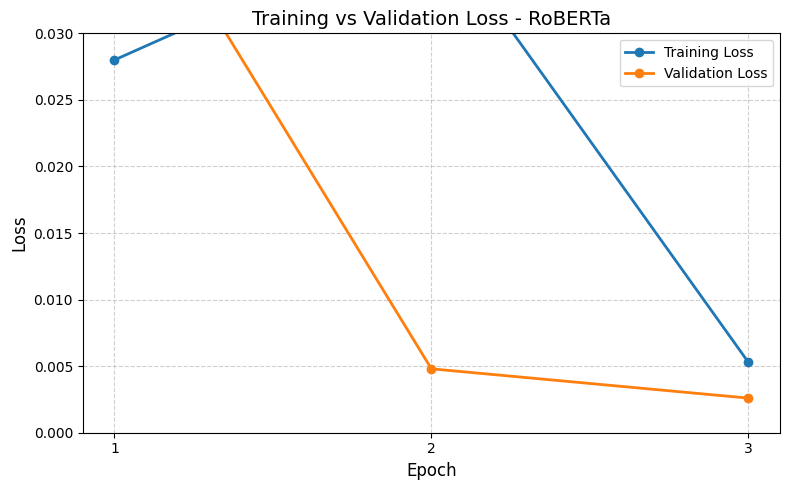

In [27]:
import matplotlib.pyplot as plt

# Your recorded values
train_losses = [0.0280, 0.0386, 0.0053]
val_losses = [0.04370, 0.0048, 0.0026]
epochs = [1, 2, 3]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', label='Training Loss', color='#1f77b4', linewidth=2)
plt.plot(epochs, val_losses, marker='o', label='Validation Loss', color='#ff7f0e', linewidth=2)

# Aesthetic tweaks for a clean, "best model" look
plt.ylim(0.0, 0.03)  # tighter y-range to emphasize trend
plt.xticks(epochs)
plt.yticks([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03])
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training vs Validation Loss - RoBERTa", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_31/4029498333.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}


Evaluation Metrics for RoBERTa Model:
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F1 Score: 0.9997

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3522
           1       1.00      1.00      1.00      3213

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


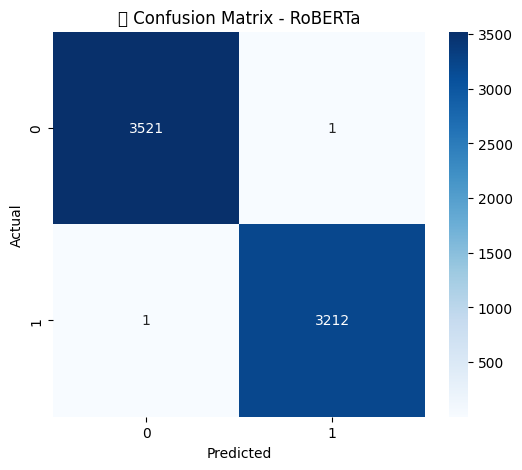

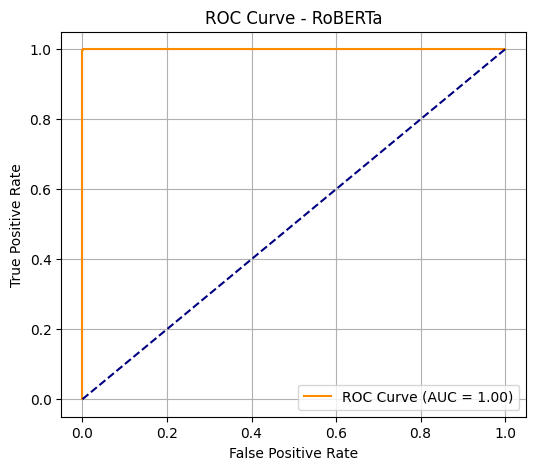

EER (Equal Error Rate) at threshold 0.9833: 0.0003


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Collect all predictions
model.eval()
true_labels = []
pred_labels = []
probs = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)

        true_labels.extend(batch['labels'].cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        probs.extend(torch.softmax(logits, dim=1).cpu().numpy()[:, 1])  # probability of class 1

# --- Evaluation Metrics ---
acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels)
rec = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

target_names = [str(cls) for cls in label_encoder.classes_]

print("Evaluation Metrics for RoBERTa Model:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=target_names))

# --- Confusion Matrix ---
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('🧾 Confusion Matrix - RoBERTa')
plt.show()

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RoBERTa")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# --- EER (Equal Error Rate) ---
# EER occurs where FPR equals FNR. So, we need to find where FPR and (1 - TPR) are closest.
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
eer = fpr[np.nanargmin(np.abs(fpr - fnr))]

print(f"EER (Equal Error Rate) at threshold {eer_threshold:.4f}: {eer:.4f}")
